In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        return x
     
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def l1norm(self, size_average=True, l1_weight=1e-5):
        l1_norm = l1_weight * torch.abs(self.data_rho)
        if size_average:
            self._l1_loss = l1_norm.mean()
        else:
            self._l1_loss = l1_norm.sum()
        return self._l1_loss
    
#     def rho_loss(self, rho, size_average=True):
#         """
#         D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
#         """
# #         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
#         dkl = - torch.log(self.data_rho) * rho - torch.log((1 - self.data_rho)) * (1 - rho)
#         if size_average:
#             self._rho_loss = dkl.mean()
#         else:
#             self._rho_loss = dkl.sum()
#         return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
l1_weight=1e-2
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
#             rho_loss = model.rho_loss(rho)
#             loss = model.loss(output, data) + rho_loss
            l1norm = model.l1norm(l1_weight=l1_weight)
            loss = model.loss(output, data) + l1norm
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.l1norm(size_average=False, l1_weight=l1_weight).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.027111 32: 1.014779 64: 1.001132
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.681664 32: 0.471991 64: 0.325314
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.451995 32: 0.319053 64: 0.273265
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.355899 32: 0.286555 64: 0.249103
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.316424 32: 0.273634 64: 0.224477
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.307075 32: 0.273532 64: 0.209361
Test set:
16: loss: 0.2979	rho_loss: 0.0099
32: loss: 0.2661	rho_loss: 0.0094
64: loss: 0.2102	rho_loss: 0.0084

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.293662 32: 0.263584 64: 0.209070
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.297608 32: 0.265669 64: 0.197254
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.283556 32: 0.249587 64: 0.179949
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.274530 32: 0.238608 64: 0.169426
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.272669 32: 0.235693 64: 0.164048
Train

Test set:
16: loss: 0.1176	rho_loss: 0.0063
32: loss: 0.0690	rho_loss: 0.0060
64: loss: 0.0323	rho_loss: 0.0055

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.113303 32: 0.064801 64: 0.028691
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.121451 32: 0.071463 64: 0.034560
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.121426 32: 0.070354 64: 0.032209
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.109666 32: 0.062682 64: 0.029181
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.129007 32: 0.072806 64: 0.033309
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.119716 32: 0.069425 64: 0.032313
Test set:
16: loss: 0.1150	rho_loss: 0.0060
32: loss: 0.0667	rho_loss: 0.0058
64: loss: 0.0310	rho_loss: 0.0054

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.112847 32: 0.066290 64: 0.031349
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.122160 32: 0.070285 64: 0.031380
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.102226 32: 0.059874 64: 0.028408
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([15, 18, 14, 16, 16, 10, 17, 12, 15, 19, 18, 17, 14, 20, 18, 17, 14, 17,
        21, 12, 17, 15, 12, 16, 10, 20, 12, 16, 18, 18, 14, 20, 19, 18, 19, 16,
        14, 18, 12, 15, 11, 11, 16, 18, 19, 16, 21, 11, 19, 12])


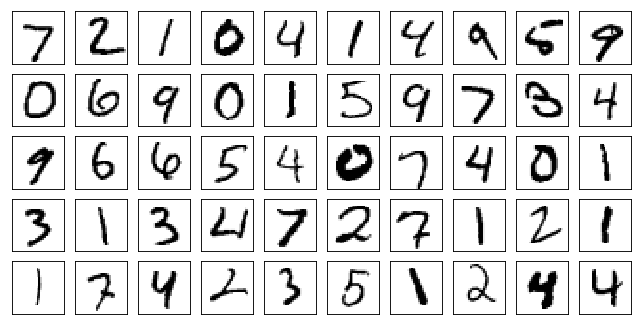

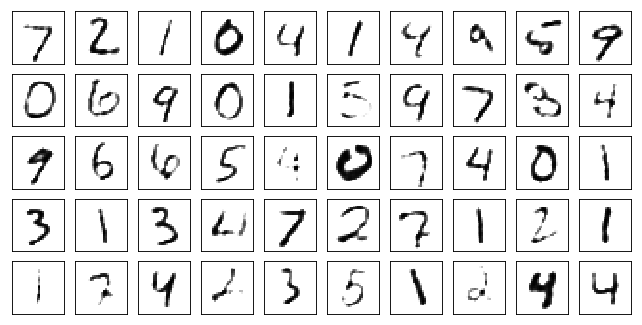

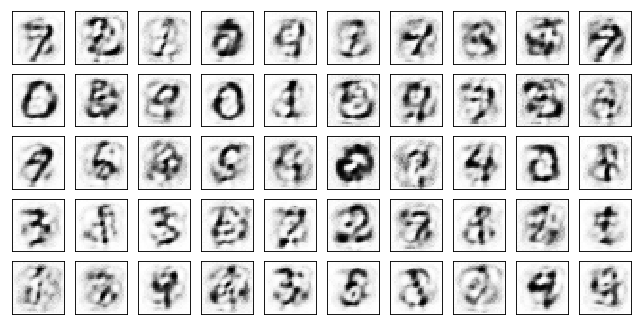

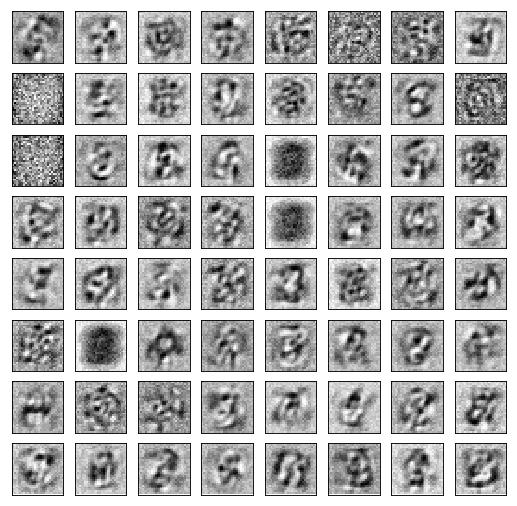

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))